# <span style="font-family: Arial, sans-serif; color:#97f788">Ordinal Classification</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">Softmax vs Ordinal</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

<span style="font-family: Arial, sans-serif; color:#97f788"> This notebook documents some experiments with ordinal classification.</span>

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from rich import print as pprint

datafile_path = (
    "data/fine_food_reviews_with_embeddings_1k.csv"
)

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(
    np.array # type: ignore
)  # type: ignore # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values),
    df.Score,
    test_size=0.3,
    random_state=42,
)

# train a logistic regression
clf_open = LogisticRegression(
    fit_intercept=True,
    solver="newton-cg",
    penalty=None,
    random_state=42,
    multi_class="multinomial",
)

clf_open.fit(X_train, y_train)
preds = clf_open.predict(X_test)
probas = clf_open.predict_proba(X_test)

report = classification_report(
    y_test, preds, output_dict=False
)
pprint(report)

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


precision    recall  f1-score   support

           1       0.66      0.61      0.63        31
           2       0.55      0.35      0.43        17
           3       0.50      0.50      0.50        16
           4       0.59      0.51      0.55        43
           5       0.88      0.95      0.92       193

    accuracy                           0.79       300
   macro avg       0.64      0.59      0.61       300
weighted avg       0.78      0.79      0.78       300

In [2]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from typing import List, Union

%config InlineBackend.figure_format = 'retina'


# Visualizer of model performance
def plot_multiclass_roc_auc(
    y_score: Union[pd.Series, pd.DataFrame],
    y_true_untransformed: Union[pd.Series, pd.DataFrame],
    class_list: List[str],
    classifier_name: str,
) -> None:
    """
    ROC AUC plotting for a multiclass problem.
    It plots the ROC curve and computes the AUC for each class,
    as well as the micro-average AUC.

    """
    n_classes = len(class_list)
    y_true = pd.concat(
        [
            (y_true_untransformed == class_list[i])
            for i in range(n_classes)
        ],
        axis=1,
    ).values

    # choose cmap tab10 from matplotlib
    colors = plt.get_cmap("Set2").colors

    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute ROC curve and ROC AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(
            y_true[:, i],
            y_score[:, i],
            drop_intermediate=False,
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_true.ravel(), y_score.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(
        f"{classifier_name} - Micro-average Gini: {roc_auc['micro'] * 2 - 1:.2f}"
    )

    # Plot ROC curves
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'Micro-Avg={roc_auc["micro"] * 2 - 1:.2f}',
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            lw=2,
            label=f"Class {class_list[i]}={roc_auc[i] * 2 - 1:.2f}",
            color=colors[i],
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("1 - TNR")
    plt.ylabel("TPR")
    plt.title("ROC curves")
    plt.legend(loc="lower right")
    plt.show()

LogisticRegression(multi_class='multinomial', penalty=None, random_state=42,
                   solver='newton-cg') - Micro-average Gini: 0.91


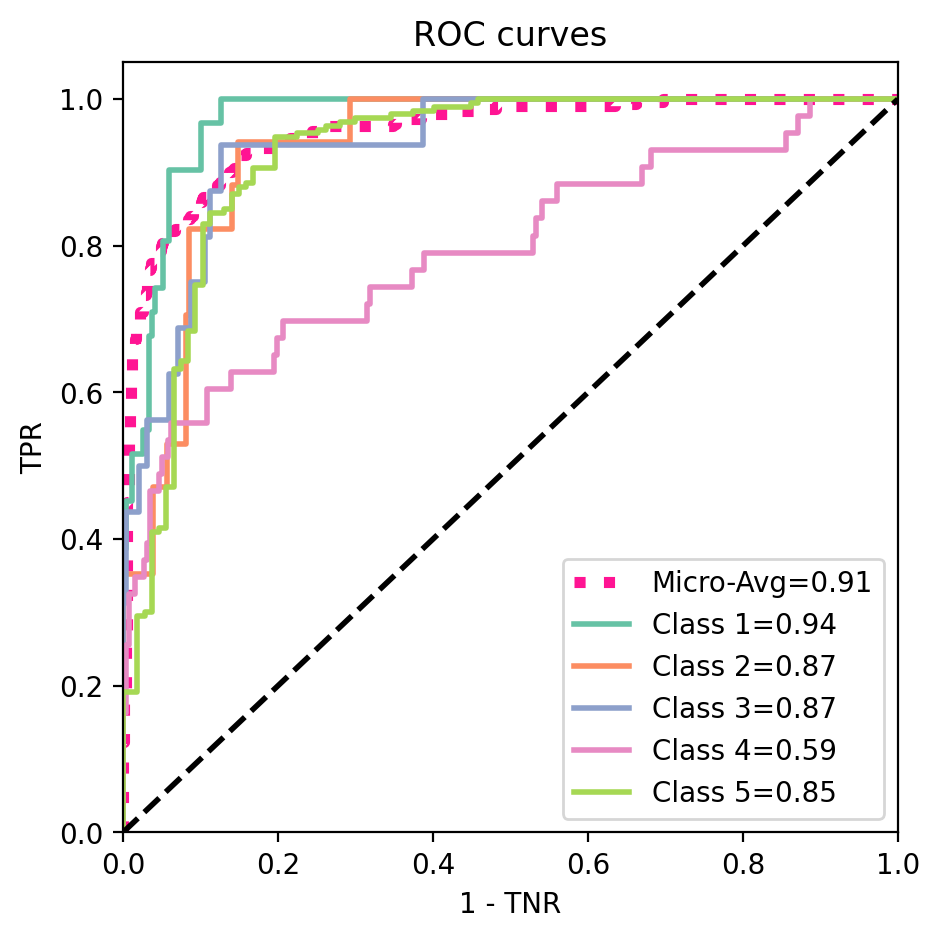

In [3]:
plot_multiclass_roc_auc(
    probas, y_test, [1, 2, 3, 4, 5], clf_open
)

### Spacecutter

In [4]:
import numpy as np
from torch import nn
from spacecutter.models import OrdinalLogisticModel
from skorch import NeuralNet
from spacecutter.callbacks import AscensionCallback
from spacecutter.losses import CumulativeLinkLoss

df_ord = df.copy()

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df_ord.embedding.values),
    df_ord.Score - 1,
    test_size=0.3,
    random_state=42,
)

X_train = np.array(X_train, dtype=np.float32).copy()
y_train = np.array(y_train).reshape(-1, 1).copy()

# Determine the number of features and classes
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

print(f"Number of unique classes: {num_classes}")

# Feedforward Neural Network
predictor = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),
    nn.Linear(128, 1)
)

model = OrdinalLogisticModel(predictor, num_classes)

ordinal_regression = NeuralNet(
    module=model,
    module__predictor=predictor,
    module__num_classes=num_classes,
    criterion=CumulativeLinkLoss,
    lr=0.2,
    max_epochs=100,
    train_split=None,
    callbacks=[
        ('ascension', AscensionCallback()),
    ],
)

ordinal_regression.fit(X_train, y_train)

Number of unique classes: 5
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0976  0.0640
      2        0.8281  0.0174
      3        0.7648  0.0159
      4        0.6758  0.0155
      5        0.6616  0.0160
      6        0.6126  0.0164
      7        0.5903  0.0164
      8        0.5698  0.0177
      9        0.5457  0.0151
     10        0.5281  0.0133
     11        0.4992  0.0146
     12        0.5080  0.0183
     13        0.4800  0.0154
     14        0.4606  0.0145
     15        0.4555  0.0353
     16        0.4641  0.0122
     17        0.4330  0.0144
     18        0.4193  0.0145
     19        0.4226  0.0127
     20        0.4204  0.0163
     21        0.3934  0.0146
     22        0.3947  0.0125
     23        0.3998  0.0137
     24        0.3923  0.0185
     25        0.3832  0.0167
     26        0.3666  0.0158
     27        0.3590  0.0159
     28        0.3590  0.0179
     29        0.3337  0.0161
     30        0.3473  0.0154
     31     

<class 'skorch.net.NeuralNet'>[initialized](
  module_=OrdinalLogisticModel(
    (predictor): Sequential(
      (0): Linear(in_features=1536, out_features=256, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=128, out_features=1, bias=True)
    )
    (link): LogisticCumulativeLink()
  ),
)

<class 'skorch.net.NeuralNet'>[initialized](
  module_=OrdinalLogisticModel(
    (predictor): Sequential(
      (0): Linear(in_features=1536, out_features=256, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=128, out_features=1, bias=True)
    )
    (link): LogisticCumulativeLink()
  ),
) - Micro-average Gini: 0.90


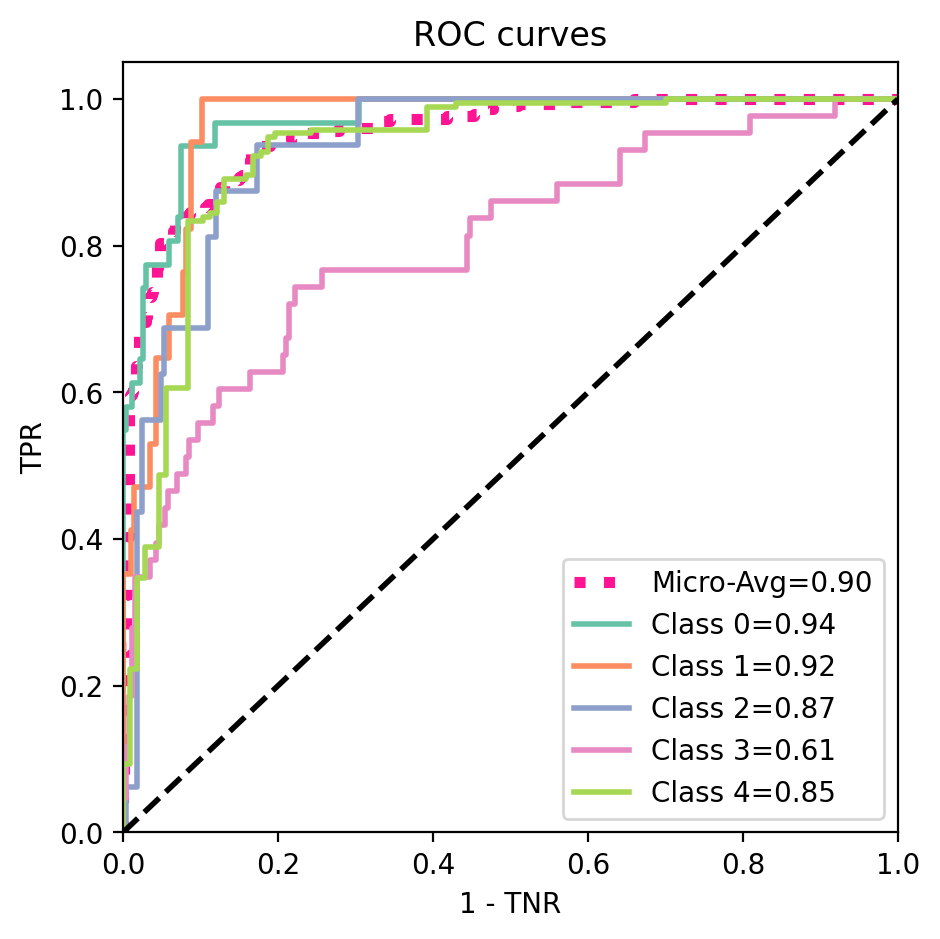

precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.67      0.35      0.46        17
           2       0.50      0.56      0.53        16
           3       0.50      0.51      0.51        43
           4       0.90      0.92      0.91       193

    accuracy                           0.80       300
   macro avg       0.66      0.62      0.63       300
weighted avg       0.79      0.80      0.79       300

In [5]:
probas_ord = ordinal_regression.predict_proba(
    np.array(X_test, dtype=np.float32)
).flatten()

preds_ord = ordinal_regression.predict(
    np.array(X_test, dtype=np.float32)
).argmax(axis=-1)

probas_ord_reshaped = probas_ord.reshape(-1, num_classes)

probas = pd.DataFrame(
    probas_ord_reshaped, 
    columns=[f'prob_class_{i}' for i in range(num_classes)]
).to_numpy()

_ = plot_multiclass_roc_auc(
    probas, y_test, [0, 1, 2, 3, 4], ordinal_regression
)

report = classification_report(y_test.values, preds_ord)
pprint(report)

### Ordinal Classification

[Source](https://github.com/mosh98/Ordinal_Classifier/blob/master/Ordinal_Classifier.py)

In [6]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from ordinal_classifier import OrdinalClassifier

from rich.console import Console

console = Console()

datafile_path = (
    "data/fine_food_reviews_with_embeddings_1k.csv"
)

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(
    np.array
)  # type: ignore

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values),
    df.Score - 1,
    test_size=0.3,
    random_state=42,
)

n_classes = len(np.unique(y_train))
X_train_, X_test_ = np.array(X_train, dtype=np.float16), np.array(X_test, dtype=np.float16)
y_train_, y_test_ = (
    np.array(y_train).reshape(-1, 1), 
    np.array(y_test).reshape(-1, 1)
)

clf_base = svm.SVC(
    probability=True,
    random_state=42,
)

clf = OrdinalClassifier(clf_base)

clf.fit(X_train_, y_train_)
preds_ord_clf = clf.predict(X_test_)
probas_ord_clf = clf.predict_proba(X_test_)

report = classification_report(
    y_test, preds_ord_clf, output_dict=False
)
console.print(report)

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

precision    recall  f1-score   support

           0       0.76      0.71      0.73        31
           1       0.80      0.47      0.59        17
           2       0.43      0.56      0.49        16
           3       0.67      0.47      0.55        43
           4       0.89      0.97      0.93       193

    accuracy                           0.82       300
   macro avg       0.71      0.64      0.66       300
weighted avg       0.82      0.82      0.81       300

### Comparison (Softmax vs Ordinal)

In [7]:
import numpy as np


def ordinal_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:

    total_count = len(y_true)

    accurate_count = sum(
        1
        for true_label, pred_label in zip(y_true, y_pred)
        if pred_label in [true_label, true_label - 1, true_label + 1]
    )
    return accurate_count / total_count


# Assuming y_test and preds are already defined
preds_lr = clf_open.predict(X_test)
preds_svm = clf.predict(X_test)

# Logistic Regression Model
accuracy_log_reg = ordinal_accuracy(y_test, preds_lr)
print(f"Ordinal Accuracy for Logistic Regression: {accuracy_log_reg:.2%}")

# Ordinal SVM Model
accuracy_ordinal_svm = ordinal_accuracy(y_test, preds_svm)
print(f"Ordinal Accuracy for Ordinal SVM: {accuracy_ordinal_svm:.2%}")

Ordinal Accuracy for Logistic Regression: 86.67%
Ordinal Accuracy for Ordinal SVM: 96.00%
